# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### Genome context analysis

Here we show how we made the graphs from the analysis obtained using the pipeline implemented in [Río et al. 2022](https://doi.org/10.1101/2022.01.26.477801)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import normaltest
from statsmodels.stats.multitest import multipletests as mt

In [2]:
data = pd.read_table('../data_folder/Genomic_context_frequency_KEGG_pathways.tsv.xz',
                     sep='\t', header='infer')

data = data.rename({'Gene_families': 'Long_families',
                   'Short_Gene_families': 'Short_families'}, axis=1)
                   
data = data.melt(id_vars=['KEGG description'],
                   value_vars=['AMPs', 'Short_families', 'Long_families'])

data.value = data.value * 100
data = data.dropna()

In [3]:
colors = {'AMPs': (254/255, 196/255, 79/255, 0.5),
          'Short_families': (254/255, 153/255, 41/255, 0.5),
          'Long_families': (140/255, 45/255, 4/255, 0.5)}

### Figure 3A

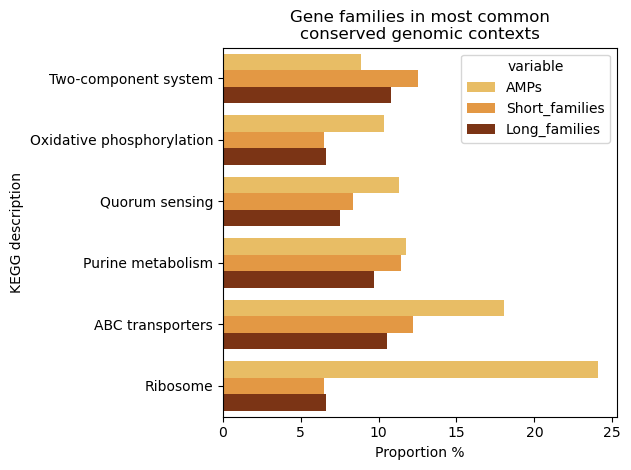

In [4]:
g1 = ['Two-component system', 'Oxidative phosphorylation',
      'Quorum sensing', 'Purine metabolism',
      'ABC transporters', 'Ribosome']

df = data[data['KEGG description'].isin(g1)]
df = pd.concat([df[df['KEGG description']==i] for i in g1])
sns.barplot(data=df,
            orient='h',
            x='value',
            y='KEGG description',
            hue='variable',
            palette=colors)

title = f'Gene families in most common\nconserved genomic contexts'            
plt.title(title)
plt.xlabel('Proportion %')
plt.tight_layout()
plt.savefig(f'panel_most common.svg')
plt.show()    

### Figure 3B

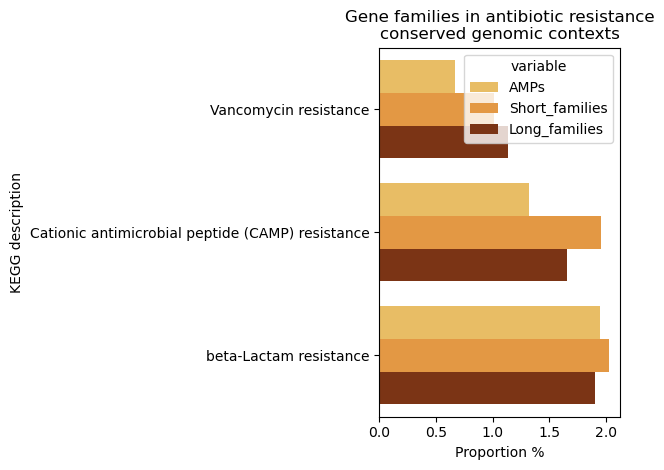

In [5]:
g2 = ['Vancomycin resistance',
      'Cationic antimicrobial peptide (CAMP) resistance',
      'beta-Lactam resistance']      

df = data[data['KEGG description'].isin(g2)]
df = pd.concat([df[df['KEGG description']==i] for i in g2])
sns.barplot(data=df,
            orient='h',
            x='value',
            y='KEGG description',
            hue='variable',
            palette=colors)

title = f'Gene families in antibiotic resistance\nconserved genomic contexts'            
plt.title(title)
plt.xlabel('Proportion %')
plt.tight_layout()
plt.savefig(f'panel_antibiotic resistance.svg')
plt.show()    

### Figure 3C

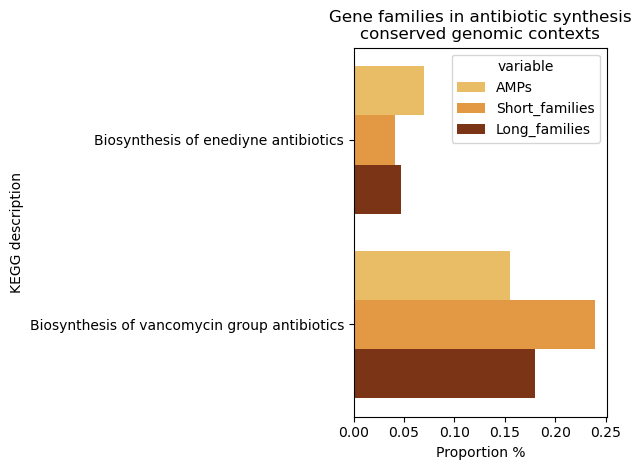

In [6]:
g3 = ['Biosynthesis of enediyne antibiotics',
      'Biosynthesis of vancomycin group antibiotics']

df = data[data['KEGG description'].isin(g3)]
df = pd.concat([df[df['KEGG description']==i] for i in g3])
sns.barplot(data=df,
            orient='h',
            x='value',
            y='KEGG description',
            hue='variable',
            palette=colors)

title = f'Gene families in antibiotic synthesis\nconserved genomic contexts'            
plt.title(title)
plt.xlabel('Proportion %')
plt.tight_layout()
plt.savefig(f'panel_antibiotic synthesis.svg')
plt.show()    

## Testing permutations

In [7]:
renames = {'all_fams': 'all_long',
           'all_fams_antibiotic': 'antibiotic_long',
           'all_fams_CARD': 'card_long',
           'short_fams': 'all_short',
           'short_fams_antibiotic': 'antibiotic_short',
           'short_fams_CARD': 'card_short'}

# setting the number of AMPs found in each
# conserved genome context determined by 
ampsphere = {'all': 21465,
             'card': 655,
             'antibiotic': 118}

In [8]:
def pval(mu=0, std=1, val=None, hypo='two-sided'):
    from scipy.stats import norm
    x = norm(0, 1)
    z = abs((val-mu)/std)
    if hypo == 'two-sided':
        return x.sf(z)*2
    return x.sf(z)

In [9]:
# loading data for the permutations
perm = pd.read_table('../data_folder/permutation_tests.tab.xz',
                     sep='\t',
                     header='infer')
                     
perm.rename(renames, axis=1, inplace=True)

In [10]:
v = []
for c in perm.columns:
    s, pnorm = normaltest(perm[c])
    test, pop = c.split('_')
    result = ['normal' if pnorm >= 0.05 else 'non-normal'][0]
    avg, std = perm[c].mean(), perm[c].std()
    val = ampsphere[test]
    n = len(perm[perm[c] > ampsphere[test]]) / 10_000
    fold = val/avg
    z = (val-avg)/std
    if result == 'normal':
        p = pval(avg, std, val, hypo='two-sided')
    else:
        p = (1/(z**2)) 
    v.append((test, pop, avg,
              std, s, pnorm,
              result, ampsphere[test],
              n, fold, z, p))

In [11]:
v = pd.DataFrame(v, columns=['test', 'population',
                             'average', 'std',
                             'normtest_statistics',
                             'normtest_p',
                             'distribution',
                             'ampsphere', 
                             'gt_ampsphere',
                             'fold', 'Z_score', 'p_value'])
       
v = v.sort_values(by=['test', 'population'])
v['p_perm'] = [2*(1 - x) if x > 0 else 0 for x in v.gt_ampsphere] 
_, v['p_value'], _, _ = mt(v['p_value'])
v

,test,population,average,std,normtest_statistics,normtest_p,distribution,ampsphere,gt_ampsphere,fold,Z_score,p_value,p_perm
0,all,long,18969.294529,111.172910,1.917897,3.832957e-01,normal,21465,0.0000,1.131566,22.448863,5.251419e-111,0.0000
3,all,short,1950.986999,43.263442,0.752187,6.865381e-01,normal,21465,0.0000,11.002124,451.050871,0.000000e+00,0.0000
1,antibiotic,long,196.445645,13.903110,1.676058,4.325623e-01,normal,118,0.9999,0.600675,-5.642309,5.033540e-08,0.0002
4,antibiotic,short,26.621962,5.057056,60.375654,7.755207e-14,non-normal,118,0.0000,4.432431,18.069413,6.116124e-03,0.0000
2,card,long,733.154615,26.880685,8.026417,1.807531e-02,non-normal,655,0.9986,0.893400,-2.907464,1.182964e-01,0.0028
5,card,short,121.919292,10.878146,1.827643,4.009890e-01,normal,655,0.0000,5.372407,49.004741,0.000000e+00,0.0000


### Supplementary Table S5

In [12]:
v.to_csv('context_comparison_ampsphere.tsv',
         sep='\t',
         header=True,
         index=None)